# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Konvolúciós neurális hálózatok - alapok
Jelen notebookban a konvolúciós hálók használatának alapjaival ismerkedünk meg. Az itteni példa publikusan elérhető kép adatbázisok két dimenziós konvolúciós hálózattal történő feldolgozásáról fog szólni. Fontos megjegyezni, hogy ahogy a konvolúciós hálók felhasználása ma már sokkal bővebb, mint pusztán képfelismerés, szinte bármilyen tématerületen sikeresen alkalmazzák (pl. beszéd, hang, idősorok, játék botok, stb.).

Az első példánkban Yann LeCunn professzor MNIST kézzel írott szám adatbázisát fogjuk betanítani a hálóval. Az adatbázis elérhető publikusan: http://yann.lecun.com/exdb/mnist/
Illetve szinte mindegyik nagyobb deep learning frameworkben be lehet tölteni parancssorból. A mostani példában előbb a Keras-t fogjuk használni, majd a Tensorflow 2.0 Keras interfészét. Az adatokat is a Keras-on keresztül töltjük be:

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
x_train.dtype

dtype('uint8')

In [3]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

batch_size=128

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű modellt softmax aktivációs függvénnyel és betanítjuk batch_size batch mérettel:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1,)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                        

In [5]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2, callbacks=[early_stopping, checkpointer, tb])

Epoch 1/30
369/375 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9256
Epoch 1: val_loss improved from inf to 0.05583, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 17s 10ms/step - loss: 0.2421 - accuracy: 0.9263 - val_loss: 0.0558 - val_accuracy: 0.9835
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9754
Epoch 2: val_loss improved from 0.05583 to 0.04438, saving model to model.hdf5
375/375 [==============================] - 4s 10ms/step - loss: 0.0843 - accuracy: 0.9754 - val_loss: 0.0444 - val_accuracy: 0.9875
Epoch 3/30
373/375 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9814
Epoch 3: val_loss improved from 0.04438 to 0.04171, saving model to model.hdf5
375/375 [==============================] - 4s 10ms/step - loss: 0.0590 - accuracy: 0.9815 - val_loss: 0.0417 - val_accuracy: 0.9879
Epoch 4/30
371/375 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9851
Epoch 4: val_loss improved from 0.04171 to 0.03655, saving model to model.hdf5
375/375 [==============================] - 3s 9ms/step - loss: 0.0486 - accura

Ezután visszatöltjük a legjobb modellt és teszteljük:

In [7]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(x_test,y_test)
print("Teszt hiba:", test_err[0], "Teszt pontosság:", test_err[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0209 - accuracy: 0.9933
Teszt hiba: 0.020944399759173393 Teszt pontosság: 0.9933000206947327


## Metrikák, tévesztési mátrix
Nézzük először, hogy hogyan tudjuk kiszámolni az osztályozáshoz tartozó legfontosabb metrikákat és hogyan tudjuk megjeleníteni a konfúziós mátrixot:

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix,classification_report
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_true = np.argmax(y_test,1)

print("test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\nKonfúziós mátrix: ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

313/313 [==============================] - 1s 2ms/step
test accuracy: 0.9933
Precision 0.9932722116229856
Recall 0.9931859624702005
f1_score 0.9932264866936645

Konfúziós mátrix: 
[[ 977    0    0    0    0    0    1    0    1    1]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    2 1024    0    0    0    1    4    0    0]
 [   0    0    1 1005    0    3    0    0    1    0]
 [   0    0    0    0  975    0    1    0    1    5]
 [   0    0    0    7    0  883    2    0    0    0]
 [   2    2    1    0    1    2  950    0    0    0]
 [   0    3    1    2    0    0    0 1019    1    2]
 [   1    0    2    1    0    0    0    1  968    1]
 [   0    0    0    0    3    4    0    2    3  997]]


A tévesztési mátrixot vizuálisan is érdemes vizsgálni:

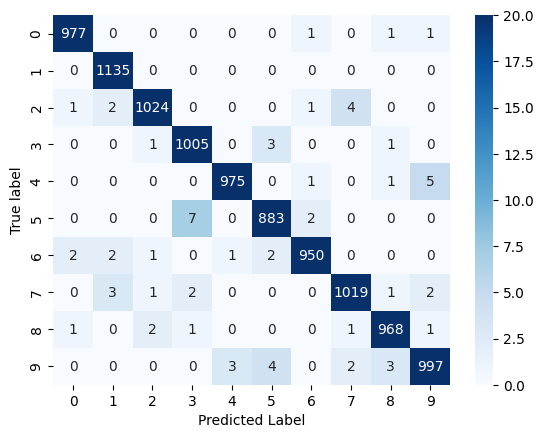

In [9]:
import seaborn as sns
ax = sns.heatmap(conf, annot=True, fmt='d', vmax=20, cmap='Blues') # a vmax paraméterrel állítjuk be, hogy milyen értéktartományban jelenítse meg az adatokat
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Fontos felhívni a figyelmet a precision, recall és f1 esetén az "avarage" paraméterre. Mivel ezek a metrikák alapvetően két osztályt vesznek figyelembe, ezért több lehetőségünk van több osztálynál az értékek figyelembe vételére. Ennek talán legegyszerűbb módja a "macro", amikor minden osztálynál kiszámolt érték átlagát veszi. Ha "micro"-ra állítjuk, akkor összegzi az összes osztály esetén a TP, TN, FN, FP értékeket és ezekkel számol. "weighted" esetben pedig azt is figyelembe veszi, hogy melyik osztályban mennyi minta van, és amelyikbe sok, azt nagyobb súllyal veszi figyelembe.

Vizsgáljuk meg a TensorBoard-ban a logokat:

In [10]:
%load_ext tensorboard

In [11]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

#Aktíváció vizsgálata a convoluciós rétegekben
https://towardsdatascience.com/visualizing-intermediate-activations-of-a-cnn-trained-on-the-mnist-dataset-2c34426416c8 alapján

In [12]:
#új modell készítése az aktivációs elemzéshez
from keras.models import Model
# Az első két réteger nézzük csak
layer_outputs = [layer.output for layer in model.layers[0:2]]
activation_model = Model(inputs=model.input,outputs=layer_outputs)

In [13]:
#Kiválasztjuk a teszthalmaz első 4 képét
img = x_test[0:4].reshape(-1,28,28,1)
#Ezek a cimkék: 7,2,1,0
np.argmax(y_test[0:4],axis=1)

array([7, 2, 1, 0])

In [14]:
#A 4 db képet ráadjuk a hálózatra:
activations = activation_model.predict(img)

1/1 [==============================] - 0s 127ms/step


In [15]:
#Kigyűjtjük a rétegek neveit
layer_names = []
for layer in model.layers[0:2]:
    layer_names.append(layer.name)


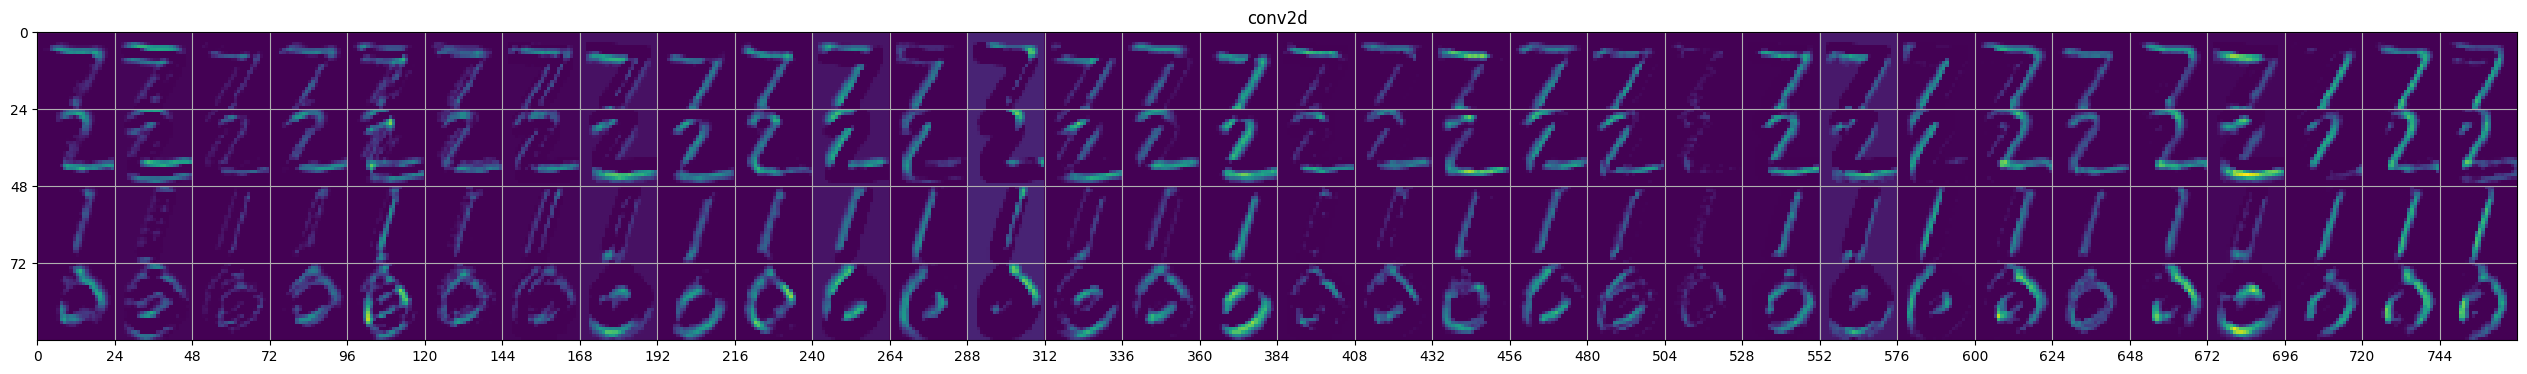

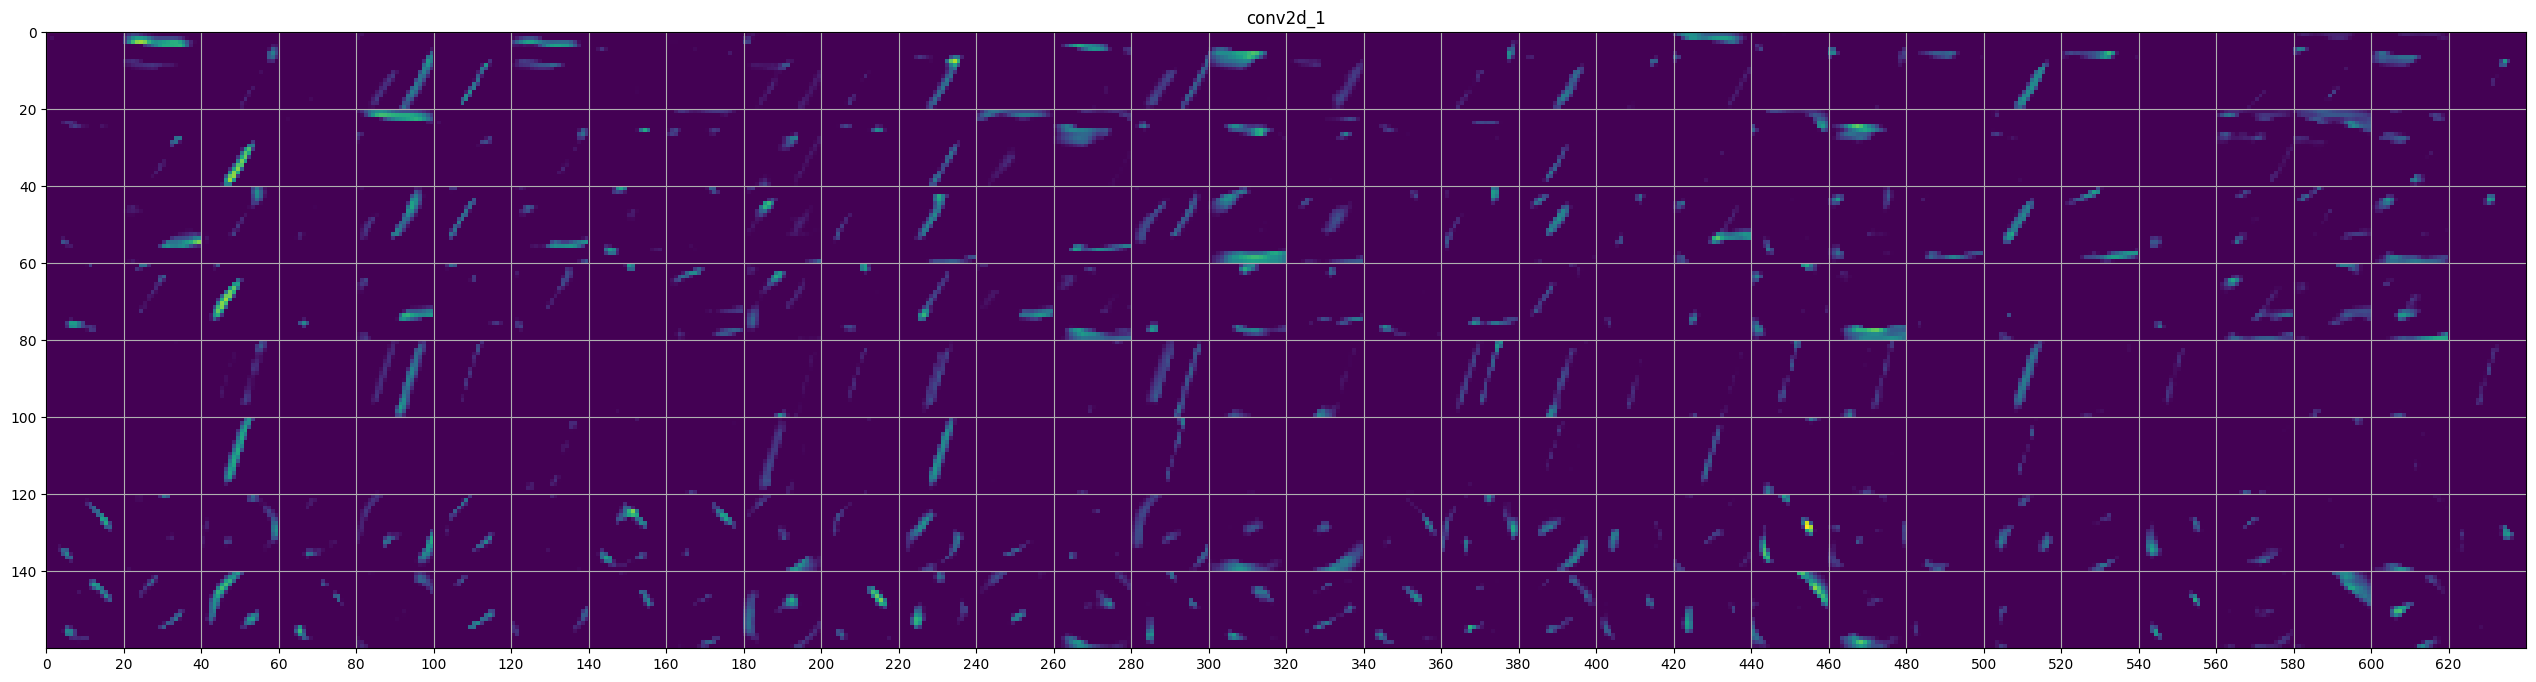

In [16]:
import matplotlib.pyplot as plt
images_per_row = 32
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    ns= layer_activation.shape[0]
    display_grid = np.zeros((size * n_cols*ns, images_per_row * size))
    for s in range(ns):
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[s,
                                             :, :,
                                             col * images_per_row + row]
            #Az aktivációt normalizálhatjuk is, ekkor kicsi más jellegű képeket kapuk. Érdemes kipróbálni True és False-al is
            #Új kép generálása előtt az aktivációt is generáljuk újra!
            if False:
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[(col) * size+ size * n_cols*s: (col + 1) * size+ size * n_cols*s, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    xticks = np.arange(0, size * images_per_row, size)
    plt.xticks(xticks - 0.5, xticks) # -0.5, because imshow places pixel centers on integer ticks so a pixel' left corner is at -0.5
    yticks = np.arange(0, size * n_cols*ns, size)
    plt.yticks(yticks - 0.5, yticks)
    plt.grid(True)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')